# Arrhytmia Dataset using CNN

Download data

In [ ]:
!wget -O archive.zip '<link-to-dataset>'

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import scipy

import itertools
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [ ]:
np.random.seed(0)

## Dataset

Load the dataset

In [ ]:
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)

inputs = len(train_df.columns) - 1
label_dict = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [ ]:
train_df[[187]] = train_df[[187]].astype(int)
test_df[[187]] = test_df[[187]].astype(int)

Augmentation functions

In [ ]:
def augment(sample, k):
  # remove padding
  for i in range(len(sample)-1, -1, -1):
    if sample[i] > 0.0:
      sample = sample[:i+1]
      break
  
  augmented_sample = scipy.signal.resample(sample, int(len(sample)*k))
  
  if len(augmented_sample) > 187:
    augmented_sample = augmented_sample[:187]
  return np.pad(np.clip(augmented_sample, 0.0, 1.0), (0, 187-len(augmented_sample)))

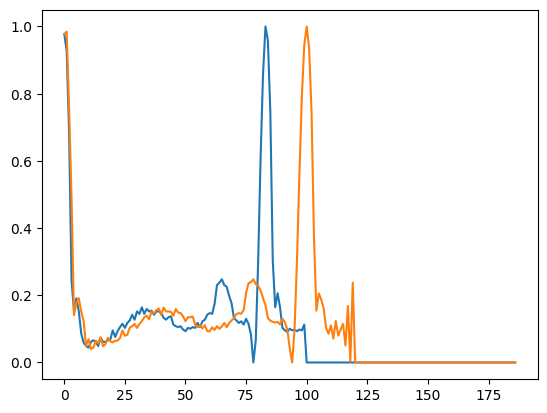

In [ ]:
plt.plot(train_df.iloc[0][:187])
plt.plot(augment(train_df.iloc[0][:187], 1.2))
plt.show()

In [ ]:
def augment_class(part_df, target_size):
  if len(part_df) > target_size:
    return sklearn.utils.resample(
        part_df,
        replace=True,
        n_samples=target_size,
        random_state=0
    )
  elif len(part_df) == target_size:
    return part_df
  
  pool = list(range(len(part_df))) * (target_size//len(part_df))
  target_size -= len(part_df)
  pool = pool[:target_size]
  new_x = []
  new_y = []
  while len(pool) > 0:
    i = pool.pop()
    new_x.append(augment(part_df.iloc[i][:187], np.random.rand()*0.4+0.8))
    new_y.append([part_df.iloc[i][187]])
  return pd.concat([part_df, pd.DataFrame(np.concatenate([new_x, new_y], axis=1))])

Examine and resample the data

Train data

187
0      72471
1       2223
2       5788
3        641
4       6431
dtype: int64


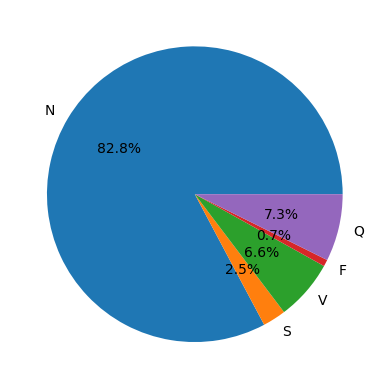

In [ ]:
plt.pie(train_df[[187]].value_counts().sort_index(), labels=label_dict.values(), autopct='%1.1f%%')
plt.plot()
print(train_df[[187]].value_counts().sort_index())

In [ ]:
train_df_grouped = [
    augment_class(train_df[train_df[187]==i], 20000) for i in label_dict
]

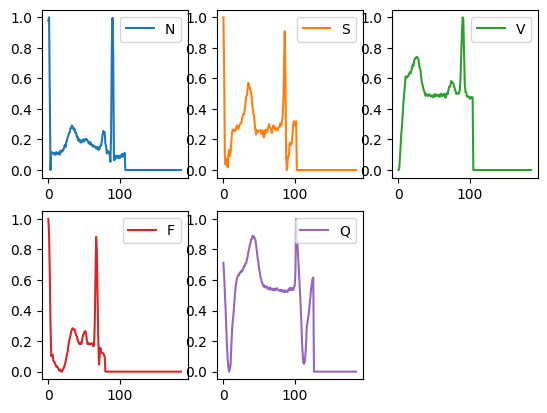

In [ ]:
for i,train_part in enumerate(train_df_grouped):
    plt.subplot(2,3,i+1)
    r=0
    for _ in range(i):
        # only for color
        plt.plot([0])
    plt.plot(train_part.iloc[r][:187], label=label_dict[train_part.iloc[r][187]])
    plt.legend()
plt.show()

187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
dtype: int64


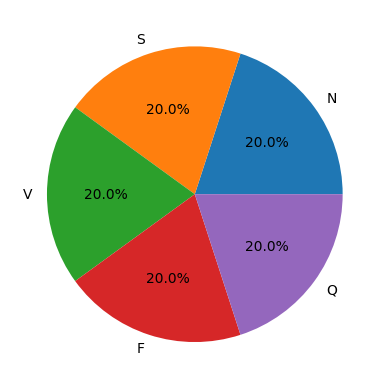

In [ ]:
train_df = pd.concat(train_df_grouped)
plt.pie(train_df[[187]].value_counts().sort_index(), labels=label_dict.values(), autopct='%1.1f%%')
plt.plot()
print(train_df[[187]].value_counts().sort_index())

In [ ]:
train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)

Test data

187
0      18118
1        556
2       1448
3        162
4       1608
dtype: int64


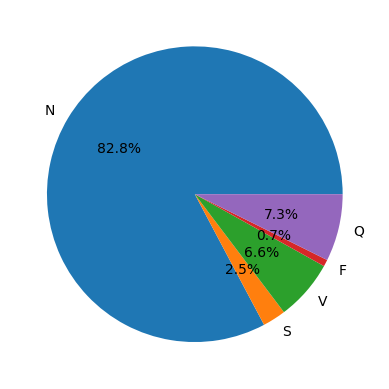

In [ ]:
plt.pie(test_df[[187]].value_counts().sort_index(), labels=label_dict.values(), autopct='%1.1f%%')
plt.plot()
print(test_df[[187]].value_counts().sort_index())

In [ ]:
test_df_grouped = [
    augment_class(
        test_df[test_df[187]==i],
        1000
    ) for i in label_dict
]

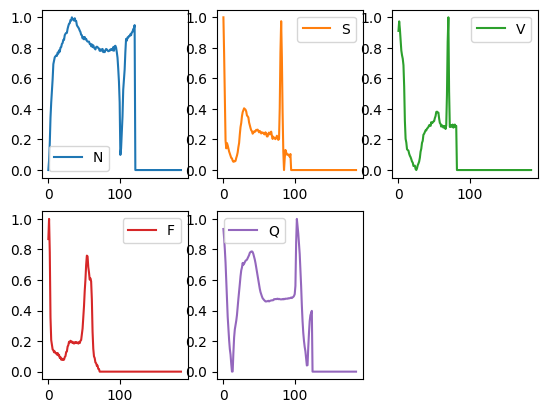

In [ ]:
for i,test_part in enumerate(test_df_grouped):
    plt.subplot(2,3,i+1)
    r=0
    for _ in range(i):
        # only for color
        plt.plot([0])
    plt.plot(test_part.iloc[r][:187], label=label_dict[test_part.iloc[r][187]])
    plt.legend()
plt.show()

187
0.0    1000
1.0    1000
2.0    1000
3.0    1000
4.0    1000
dtype: int64


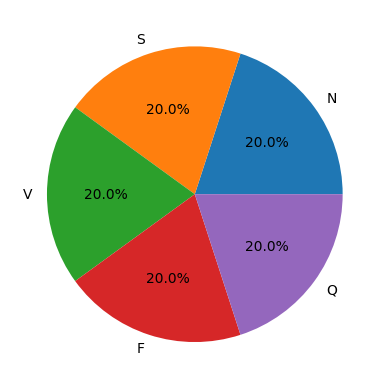

In [ ]:
test_df = pd.concat(test_df_grouped)
plt.pie(test_df[[187]].value_counts().sort_index(), labels=label_dict.values(), autopct='%1.1f%%')
plt.plot()
print(test_df[[187]].value_counts().sort_index())

In [ ]:
test_df = test_df.sample(frac=1, random_state=0).reset_index(drop=True)

Input and output separation and one-hot encoding

In [ ]:
train_x = train_df[list(range(187))]
train_y = train_df[[187]]
test_x = test_df[list(range(187))]
test_y = test_df[[187]]

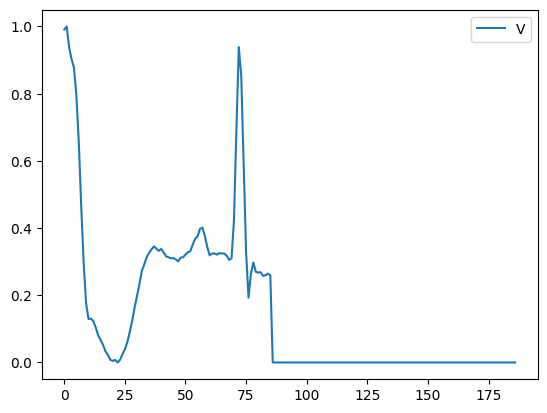

In [ ]:
r=800
plt.plot(train_x.iloc[r], label=label_dict[train_y.iloc[r].values[0]])
plt.legend()
plt.show()

In [ ]:
train_y = tf.one_hot(train_y.values.reshape((-1)), 5)
test_y = tf.one_hot(test_y.values.reshape((-1)), 5)

In [ ]:
train_x = train_x.values.reshape((-1,187,1))
test_x = test_x.values.reshape((-1,187,1))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(100000, 187, 1)
(100000, 5)
(5000, 187, 1)
(5000, 5)


## Convolutional Model

### Arch

CNN Model
Based on the architecture from "ECG Heartbeat Classification: A Deep Transferable
Representation" paper (https://arxiv.org/abs/1805.00794)

> Here, all convolution layers
are applying 1-D convolution through time and each have 32
kernels of size 5.

In [ ]:
def make_conv1d(prev_layer):
    return tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='same')(prev_layer)

> We also use max pooling of size 5 and stride
2 in all pooling layers.

In [ ]:
def make_maxpool1d(prev_layer):
    return tf.keras.layers.MaxPool1D(pool_size=5, strides=2)(prev_layer)

> The predictor network consists of five residual blocks followed by two fully-connected layers with 32 neurons each and a softmax layer to predict output class probabilities. Each residual block contains two convolutional layers, two ReLU nonlinearities, a residual skip connection, and a pooling layer. In total, the resulting network is a deep network consisting of 13 weight layers.

In [ ]:
def make_activation(prev_layer):
    return tf.keras.layers.Activation('relu')(prev_layer)

In [ ]:
def make_block(prev_layer):
    block = make_conv1d(prev_layer)
    block = make_activation(block)
    block = make_conv1d(block)
    block = tf.keras.layers.Add()([block, prev_layer])
    block = make_activation(block)
    return make_maxpool1d(block)

In [ ]:
def make_model():
    input_layer = tf.keras.layers.Input(shape=(187,1))
    model_arch = tf.keras.layers.Conv1D(filters=32, kernel_size=5)(input_layer)
    
    for i in range(5):
        model_arch = make_block(model_arch)
    
    model_arch = tf.keras.layers.Flatten()(model_arch)
    model_arch = tf.keras.layers.Dense(32)(model_arch)
    model_arch = make_activation(model_arch)
    model_arch = tf.keras.layers.Dense(32)(model_arch)
    model_arch = tf.keras.layers.Dense(5)(model_arch)
    model_arch = tf.keras.layers.Softmax()(model_arch)
    
    return tf.keras.Model(inputs=input_layer, outputs=model_arch)

In [ ]:
model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 183, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

> ... we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations

In [ ]:
decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.75
)
optimizer = tf.keras.optimizers.Adam(learning_rate=decay) # default values are equal to the ones from the paper

> Cross entropy loss on the softmax outputs is used as the loss function.

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Training

In [ ]:
history = model.fit(x=train_x, y=train_y, batch_size=1024, epochs=44, verbose=1, validation_data=(test_x, test_y))

#model = tf.keras.models.load_model('model')

Epoch 1/44
98/98 [==============================] - 20s 39ms/step - loss: 0.8535 - categorical_accuracy: 0.6690 - val_loss: 0.4954 - val_categorical_accuracy: 0.8274
Epoch 2/44
98/98 [==============================] - 3s 30ms/step - loss: 0.4429 - categorical_accuracy: 0.8442 - val_loss: 0.3783 - val_categorical_accuracy: 0.8588
Epoch 3/44
98/98 [==============================] - 3s 29ms/step - loss: 0.3254 - categorical_accuracy: 0.8867 - val_loss: 0.3093 - val_categorical_accuracy: 0.8946
Epoch 4/44
98/98 [==============================] - 3s 28ms/step - loss: 0.2691 - categorical_accuracy: 0.9061 - val_loss: 0.3131 - val_categorical_accuracy: 0.8924
Epoch 5/44
98/98 [==============================] - 3s 27ms/step - loss: 0.2295 - categorical_accuracy: 0.9202 - val_loss: 0.2731 - val_categorical_accuracy: 0.9050
Epoch 6/44
98/98 [==============================] - 3s 27ms/step - loss: 0.2093 - categorical_accuracy: 0.9261 - val_loss: 0.2352 - val_categorical_accuracy: 0.9202
Epoch 7/4

In [ ]:
model.save('model.h5')
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

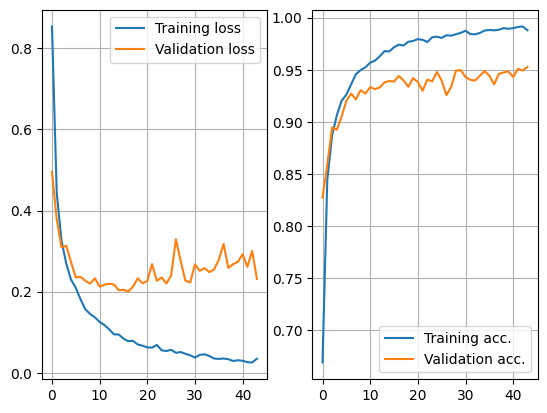

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='Training acc.')
plt.plot(history.history['val_categorical_accuracy'], label='Validation acc.')
plt.legend()
plt.grid()
plt.show()

In [ ]:
pred_y = model(test_x)
pred_y

<tf.Tensor: shape=(5000, 5), dtype=float32, numpy=
array([[9.9990726e-01, 9.2773538e-05, 5.3758629e-09, 3.3930917e-11,
        2.1529600e-13],
       [2.8894158e-11, 2.6106647e-10, 9.8677677e-01, 1.3223183e-02,
        4.0288439e-09],
       [4.6264584e-15, 8.4311339e-15, 2.6926874e-11, 2.5715154e-24,
        1.0000000e+00],
       ...,
       [4.5170543e-07, 9.9998534e-01, 5.4951397e-07, 1.7060845e-08,
        1.3582034e-05],
       [3.7287465e-12, 4.0881231e-13, 1.0000000e+00, 2.5424873e-09,
        2.3418177e-11],
       [6.2506082e-17, 1.7582596e-13, 1.0000000e+00, 4.9895542e-13,
        8.5932306e-14]], dtype=float32)>

In [ ]:
true_y = np.argmax(test_y, axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(true_y, pred_y))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1000
           1       0.96      0.92      0.94      1000
           2       0.93      0.95      0.94      1000
           3       0.95      0.94      0.95      1000
           4       0.99      0.99      0.99      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



[[957  22  10   8   3]
 [ 56 916  13  14   1]
 [  4  12 954  26   4]
 [  5   4  47 944   0]
 [  2   1   2   2 993]]


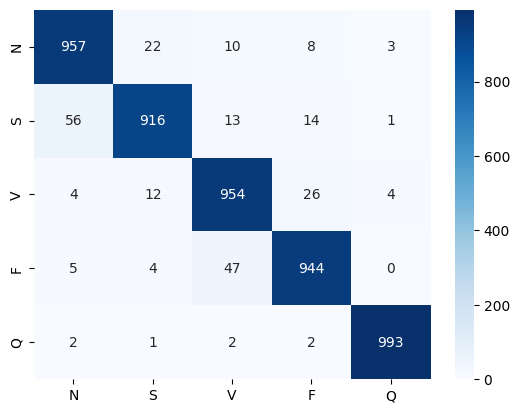

In [ ]:
matrix = confusion_matrix(true_y, pred_y)
print(matrix)
matrix_df = pd.DataFrame(matrix, index=list(label_dict.values()), columns=list(label_dict.values()))
ax = sn.heatmap(matrix_df, cmap='Blues', annot=True, fmt='g')

Test load

In [ ]:
#model = tf.keras.models.load_model('model.h5')

In [ ]:
#pred_y = model(test_x)
#true_y = np.argmax(test_y, axis=1)
#pred_y = np.argmax(pred_y, axis=1)
#print(classification_report(true_y, pred_y))
#matrix = confusion_matrix(true_y, pred_y)
#print(matrix)
#matrix_df = pd.DataFrame(matrix, index=list(label_dict.values()), columns=list(label_dict.values()))
#ax = sn.heatmap(matrix_df, cmap='Blues', annot=True, fmt='g')

### Playing around

In [ ]:
initial_lrs = [0.001, 0.01, 0.03]
decay_steps = [10000, 1000, 100]
batch_sizes = [256, 1024, 2048]


def info_to_string(ilr, ds, dr, bs):
  return "Initial lr = "+str(ilr)+", decay steps = "+str(ds)+", decay rate = "+str(dr)+", batch size = "+str(bs)


iterables = [initial_lrs, decay_steps, batch_sizes]
models = []
model_info = []
histories = []

for ilr, ds, bs in itertools.product(*iterables):
  decay = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=ilr,
      decay_steps=ds,
      decay_rate=0.75
  )
  optimizer = tf.keras.optimizers.Adam(learning_rate=decay)
  models.append(make_model())
  models[-1].compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model_info.append(info_to_string(ilr, ds, 0.75, bs))
  print("Model " + str(len(models)))
  histories.append(models[-1].fit(x=train_x, y=train_y, batch_size=bs, epochs=50, verbose=1, validation_data=(test_x, test_y)))

Model 1
Epoch 1/50
391/391 [==============================] - 10s 11ms/step - loss: 0.5454 - categorical_accuracy: 0.8025 - val_loss: 0.3128 - val_categorical_accuracy: 0.8886
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 0.2564 - categorical_accuracy: 0.9118 - val_loss: 0.2575 - val_categorical_accuracy: 0.9094
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 0.1845 - categorical_accuracy: 0.9365 - val_loss: 0.2318 - val_categorical_accuracy: 0.9238
Epoch 4/50
391/391 [==============================] - 5s 14ms/step - loss: 0.1446 - categorical_accuracy: 0.9507 - val_loss: 0.2384 - val_categorical_accuracy: 0.9172
Epoch 5/50
391/391 [==============================] - 4s 11ms/step - loss: 0.1181 - categorical_accuracy: 0.9593 - val_loss: 0.2117 - val_categorical_accuracy: 0.9370
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0983 - categorical_accuracy: 0.9666 - val_loss: 0.1858 - val_categorical_accura

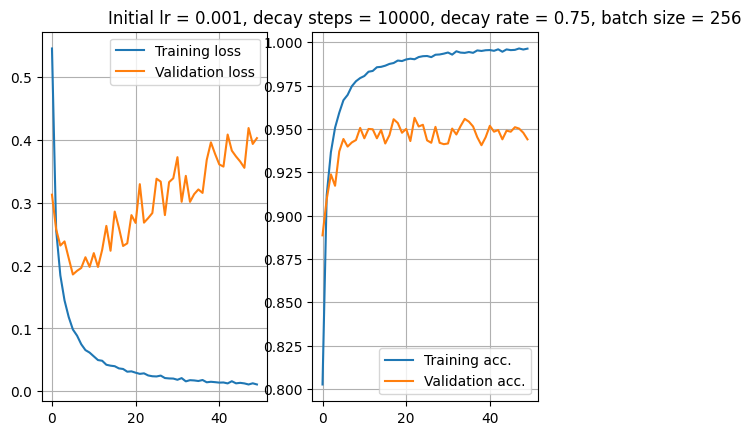

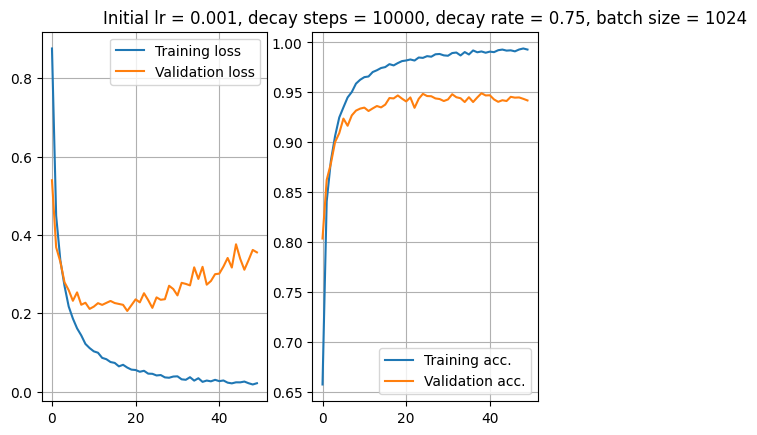

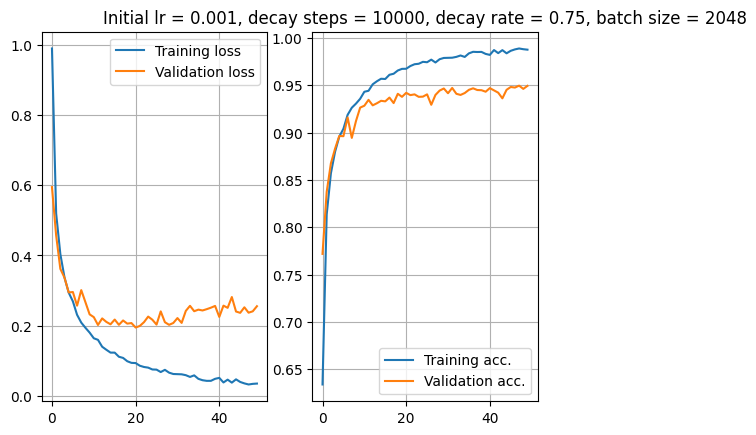

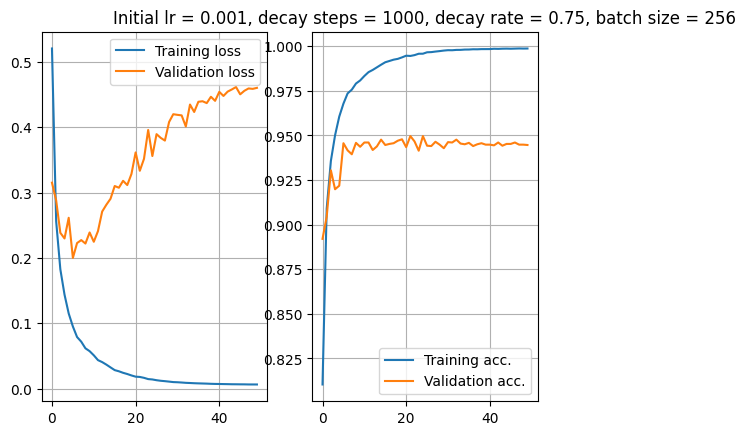

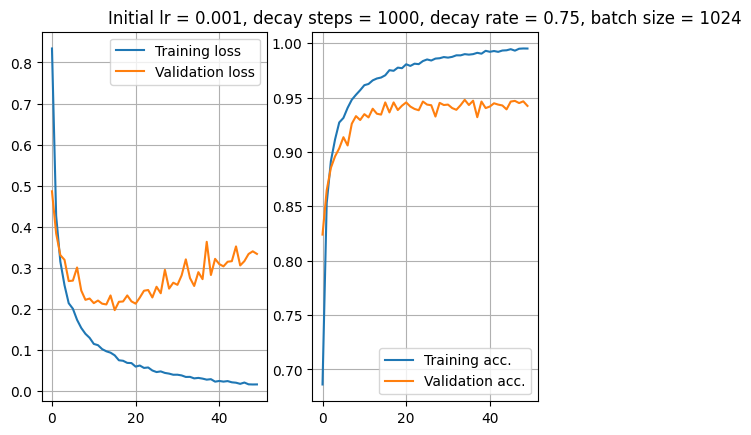

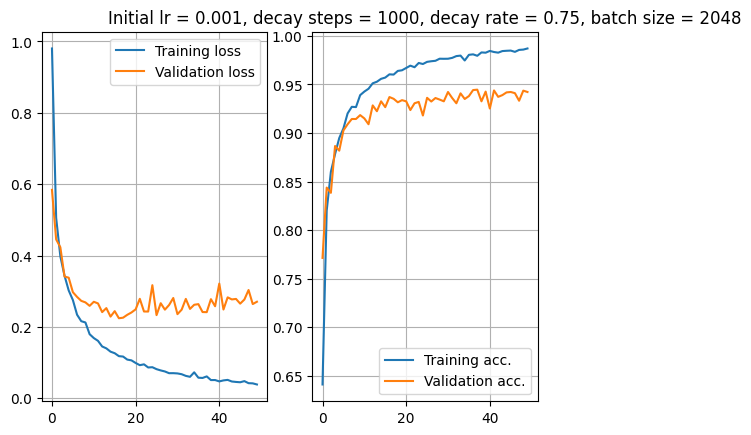

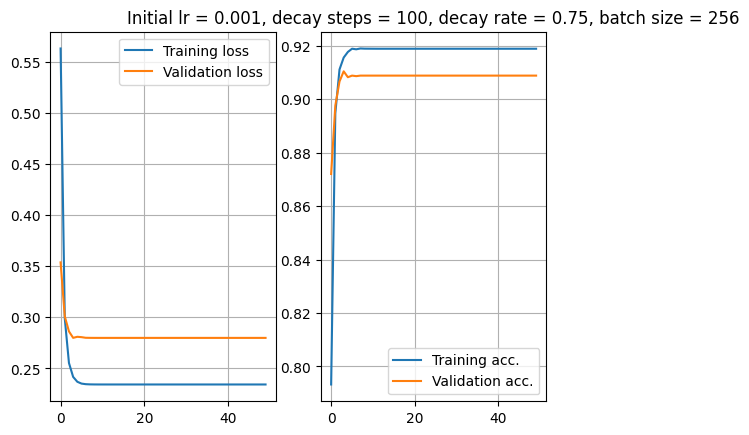

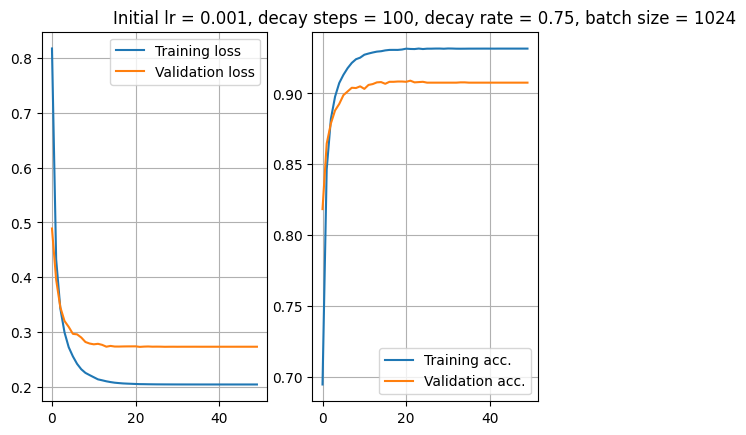

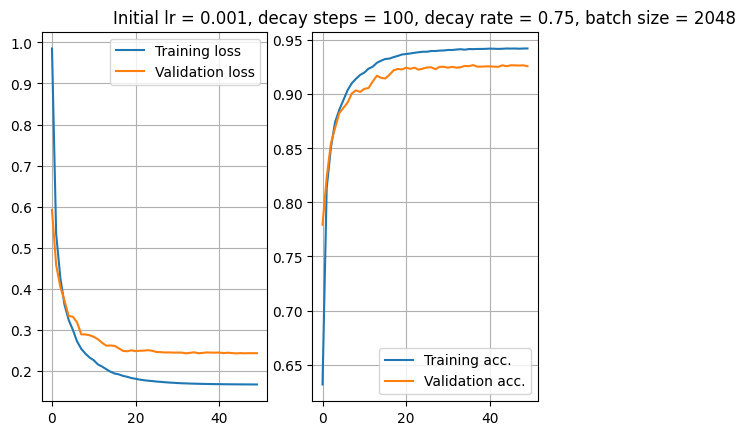

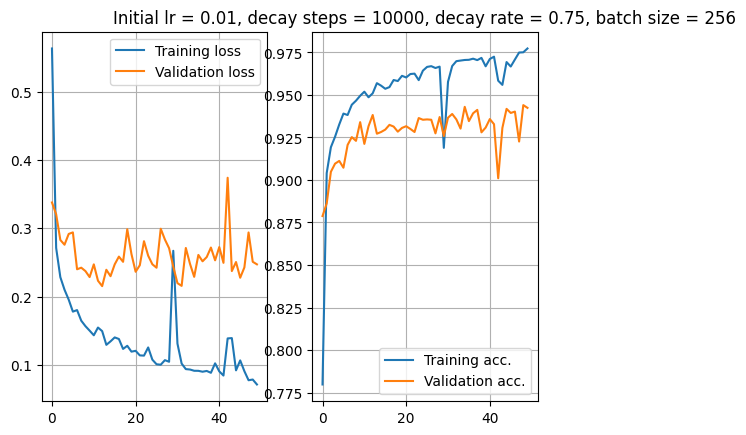

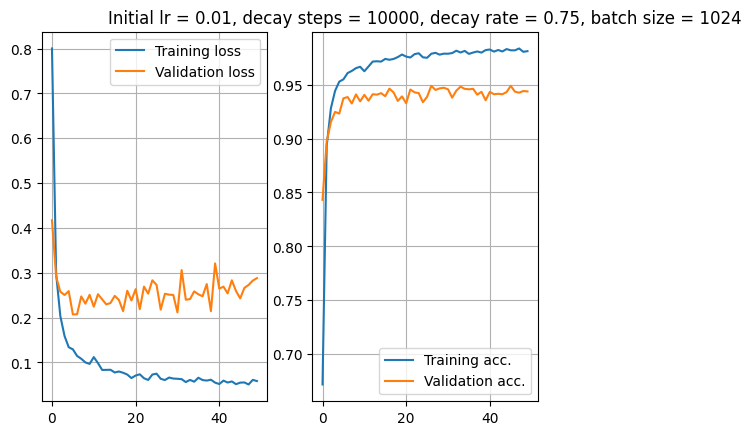

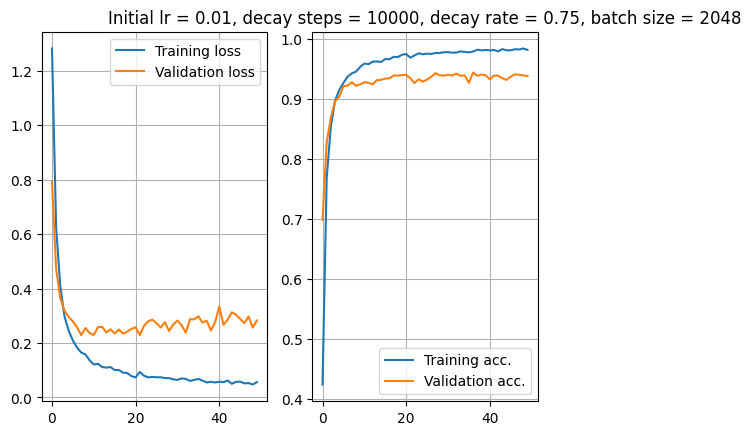

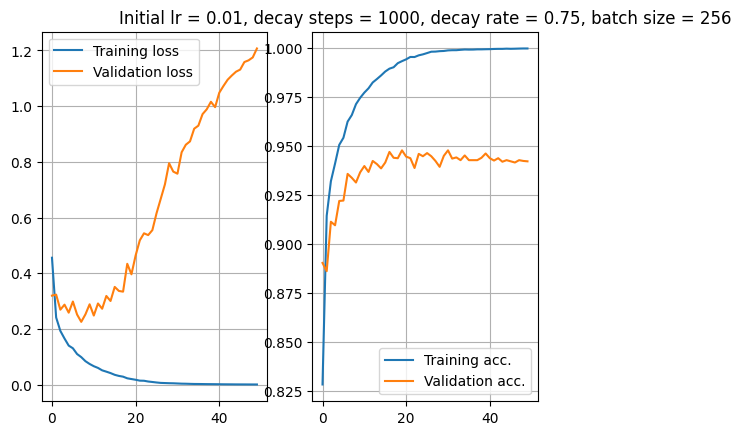

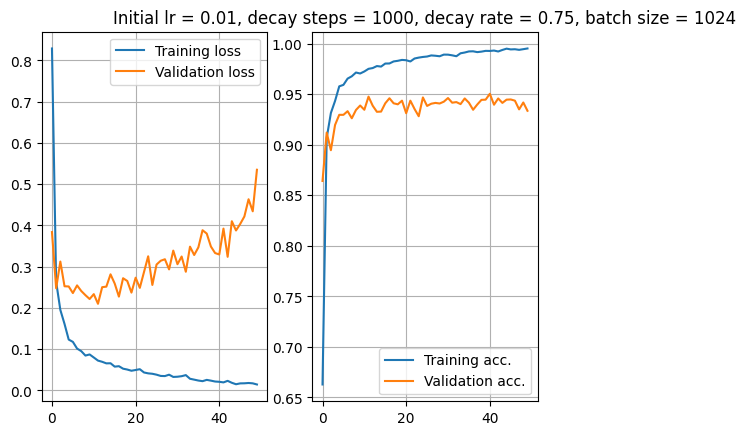

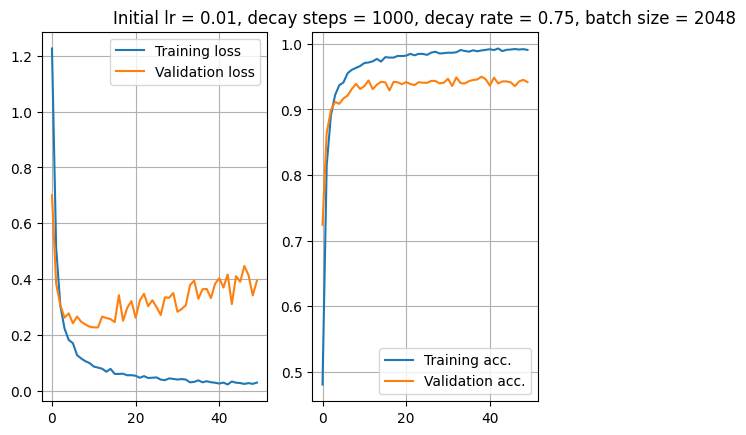

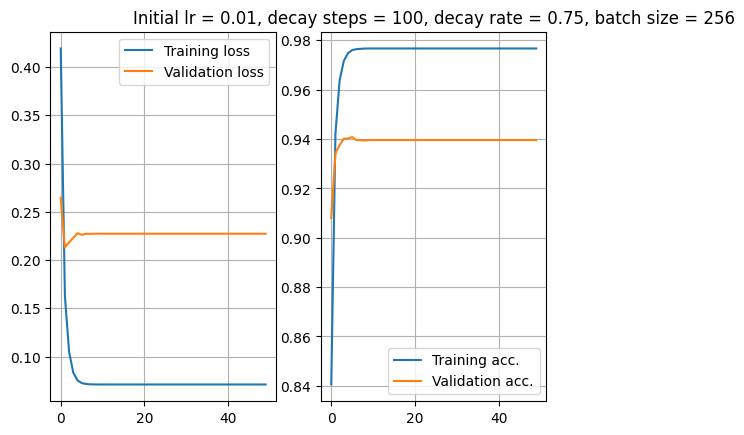

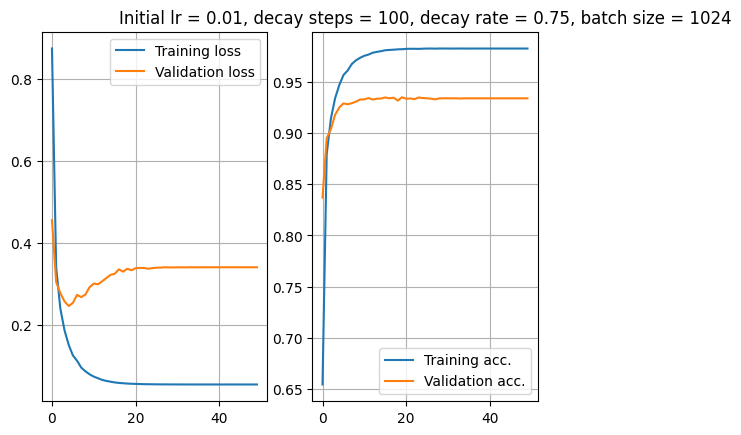

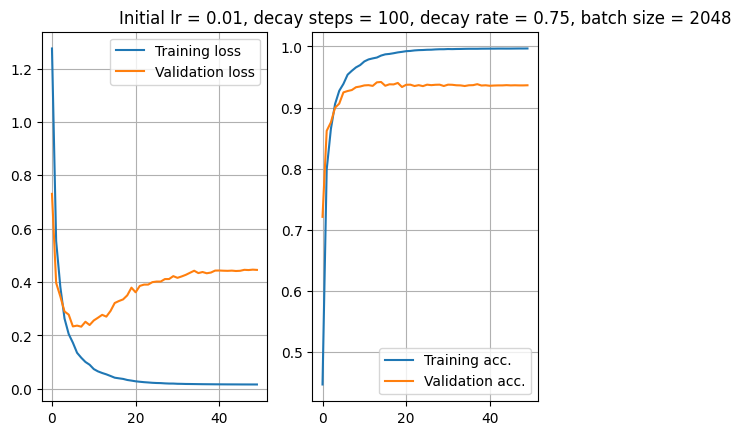

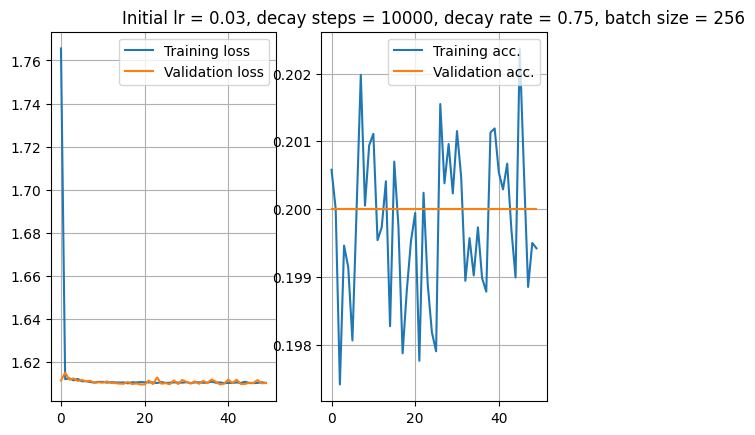

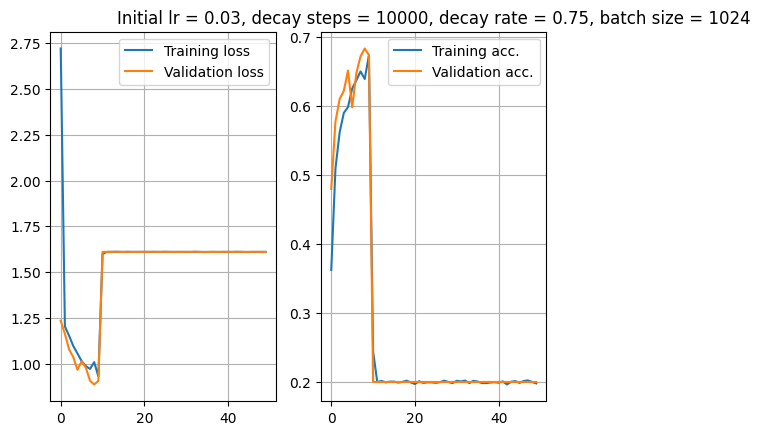

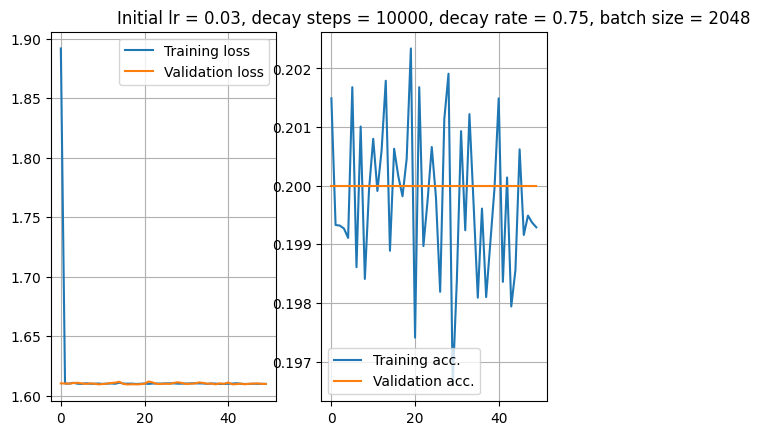

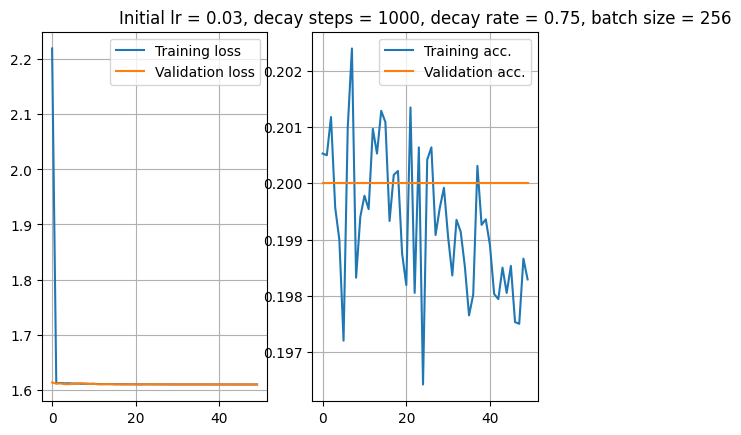

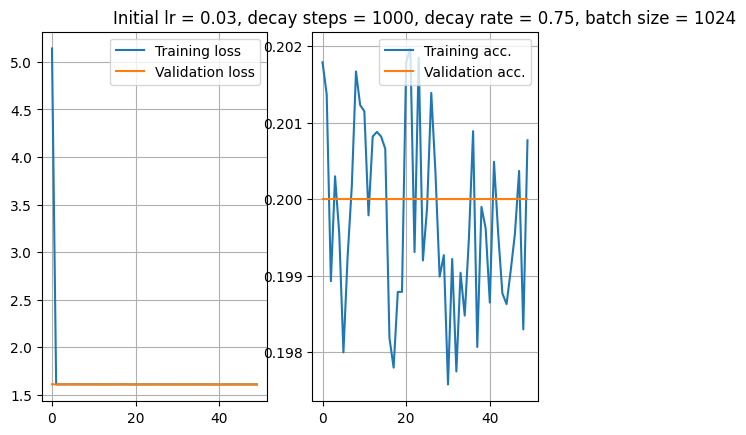

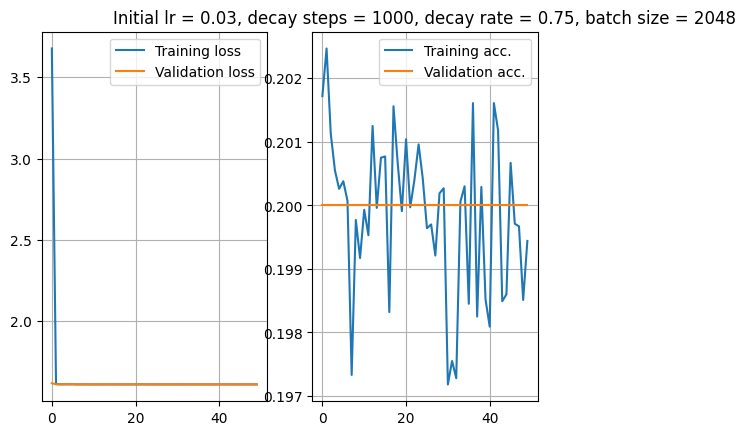

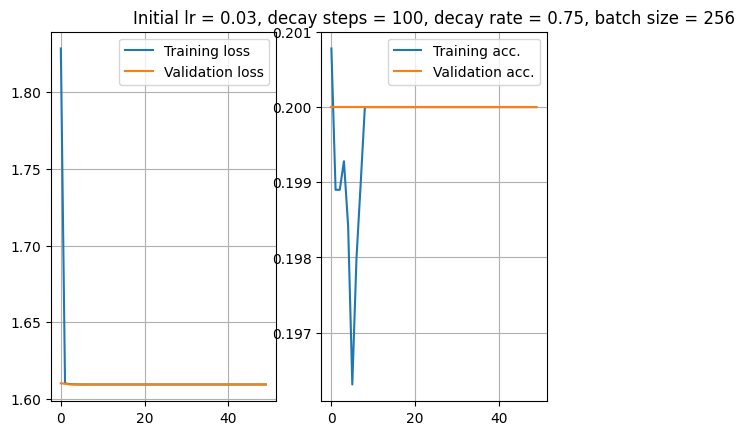

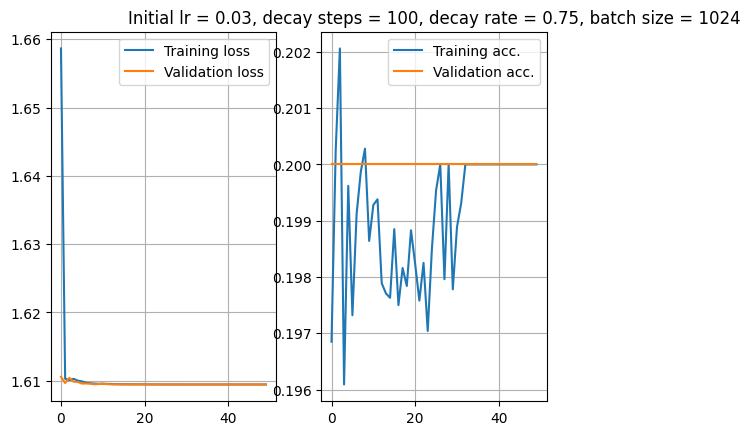

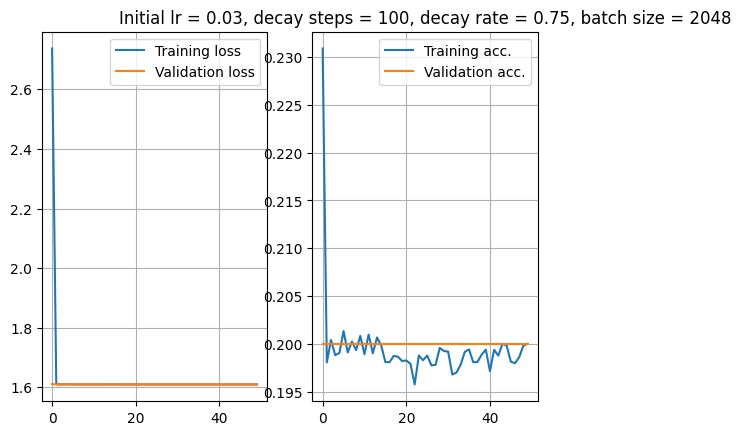

In [ ]:
for i in range(27):
  plt.subplot(1,2,1)
  plt.plot(histories[i].history['loss'], label='Training loss')
  plt.plot(histories[i].history['val_loss'], label='Validation loss')
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(histories[i].history['categorical_accuracy'], label='Training acc.')
  plt.plot(histories[i].history['val_categorical_accuracy'], label='Validation acc.')
  plt.legend()
  plt.grid()
  plt.title(model_info[i])
  plt.show()